In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split 

from sklearn.model_selection import StratifiedKFold

import cudf 
from cuml.linear_model import LogisticRegression
from cuml.ensemble import RandomForestClassifier

import os,glob

In [3]:
project_dir = os.getcwd()
data_dir = os.path.join(project_dir, 'data')

data_csv = pd.read_csv(os.path.join(data_dir, 'train.csv'))

family_history_diabetes    0.211064
age                        0.161162
systolic_bp                0.107132
bmi                        0.105580
ldl_cholesterol            0.102771
triglycerides              0.090635
cholesterol_total          0.088112
waist_to_hip_ratio         0.081050
diastolic_bp               0.036271
hypertension_history       0.029979
Name: diagnosed_diabetes, dtype: float64


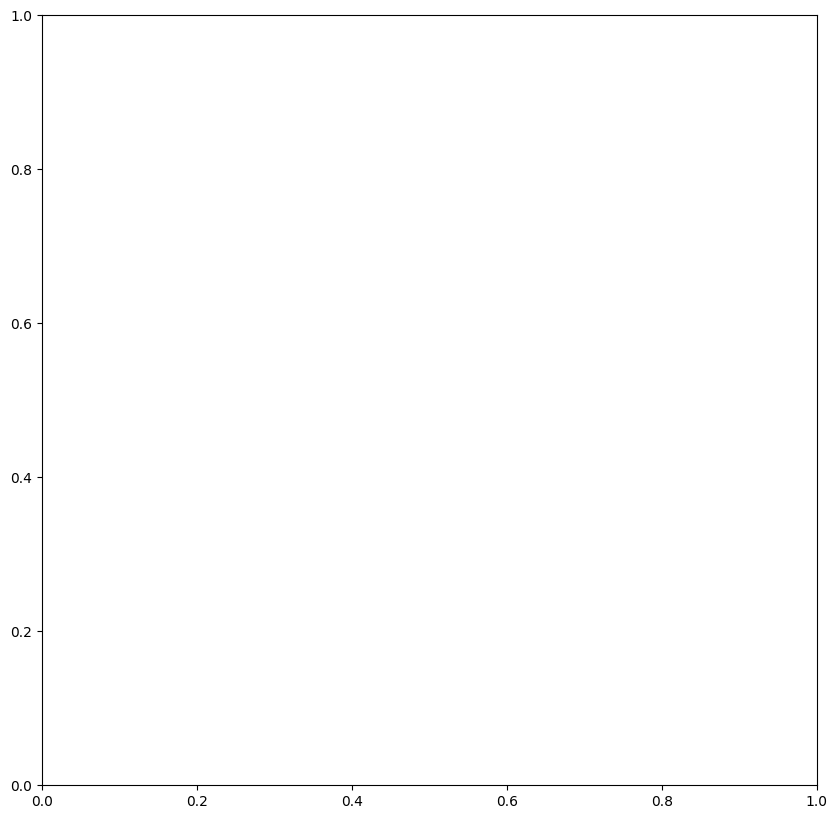

In [ ]:
numerical_data  = data_csv.select_dtypes(include=[np.number])
corr_matrix     = numerical_data.corr()

diabetes_corr = corr_matrix['diagnosed_diabetes'].drop('diagnosed_diabetes').sort_values(ascending=False)


print(diabetes_corr.abs().head(10))

# fig, ax = plt.subplots(figsize=(10, 10)) 
# colors = ['green' if x > 0 else 'red' for x in diabetes_corr]
# diabetes_corr.plot(kind='barh', color=colors, figsize=(6, 6)) 

In [ ]:
def clinical_features(df_raw):

    df = df_raw.copy()

    ### Risk Factors ###

    df['ada_risk_factor_count'] = (
        (df['gender'] == 'Male').astype(int)
        + (df['age'] > 35).astype(int)
        + (df['bmi'] >= 25).astype(int)
        + (df['bmi'] >= 30).astype(int)
        + (df['bmi'] >= 35).astype(int)
        + (df['physical_activity_minutes_per_week'] < 100).astype(int)
        + (df['systolic_bp'] >= 130) | (df['diastolic_bp'] >= 80).astype(int)
        + (df['hdl_cholesterol'] < 35).astype(int)
        + (df['triglycerides'] > 150).astype(int)
        + df['family_history_diabetes'] 
        + df['hypertension_history']  
        + df['cardiovascular_history'] 
        )

    df['bp_normal'] = (
        (df['systolic_bp'] < 120) & 
        (df['diastolic_bp'] < 80) ).astype(int)

    # LIFE STYLE
    df['toxic_lifestyle'] = (
        (df['diet_score'] < 5).astype(int) +
        (df['sleep_hours_per_day'] < 7).astype(int) +
        (df['screen_time_hours_per_day'] > 6).astype(int) +
        (df['alcohol_consumption_per_week'] > 7).astype(int) +
        (df['physical_activity_minutes_per_week'] < 100).astype(int)
    )
     
    df['age_bmi'] = df['age'] * df['bmi']

    df['age_family_history'] = df['age'] * df['family_history_diabetes']
    df['bmi_family_history'] = df['bmi'] * df['family_history_diabetes']
    df['age_bmi_family_history'] = df['age'] * df['bmi'] * df['family_history_diabetes']
    
    # cardiovascular burden 
    df['cardio_comorbidity_count'] = (
        df['hypertension_history'] +
        df['cardiovascular_history'] +
        df['family_history_diabetes']
    )

    return df
    
data_csv2 = clinical_features(data_csv)